<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>


# Dask Arrays

**ESDS dask tutorial | 06 February, 2023**  

Brian Vanderwende and Negin Sobhani  
Computational & Information Systems Lab (CISL)  
[vanderwb@ucar.edu](mailto:vanderwb@ucar.edu) and [negins@ucar.edu](negins@ucar.edu)


---------

## Dask Arrays 

Dask arrays provide distrbuted, larger-than-memory, n-dimensional array using blocked algorithms. Blocked algorithms organizes large computations by performing smaller computations on coniguous chunks of data. 


<img src="https://docs.dask.org/en/stable/_images/dask-array.svg" width="500px" style="vertical-align:middle;margin:30px 0px"/>


Dask arrays are composed of many NumPy (or NumPy-like) arrays. Dask basically divides the arrays into many small pieces (called **chunks**) that fits into the memory and minimize the memory footprint of your computation by effectively streaming data from disk.


**Dask Arrays are lazy!**

Unlike Numpy, operations on Dask arrays are not computed until you explicitly request them. 

Operations queue up a series of tasks mapped over blocks, and no computation is performed until you explicitly ask values to be computed. At that point, data is loaded into memory and computation proceeds in a streaming fashion, block-by-block.

<div class="alert alert-block alert-info" markdown="1">

<b>Lazy Evaluation: objects are evaluated just in time when the results are needed!</b> 
</div>


### In this tutorial, you learn:

* Basic concepts and features of Dask Arrays
* Working with Dask arrays

**Related Documentation**

* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)


## Setup: Start a Dask Client for Dashboard

Starting the Dask Client is not necessary for this tutorial. It will provide a dashboard which is useful to gain insight on the computation.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41385,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:39462,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/44078/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:41430,


-----------------

## Blocked Algorithms

Blocked algorithms organizes large computations by performing smaller computations on smaller chunks of data. 

Let's start by creating a NumPy array of ones:

In [1]:
import numpy as np

shape = (4000,6000)

ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Now, let's create the same array using dask:

In [2]:
import dask.array as da
ones_da = da.ones(shape)
ones_da

dask.array<ones_like, shape=(4000, 6000), dtype=float64, chunksize=(4000, 3000), chunktype=numpy.ndarray>

We see a dask array representation of the data. This is a symbolic representation. No data has actually been generated yet - this mode of operation is called **'lazy'**. It allows the user to build up a series of computations or tasks before being passed to the scheduler for execution.

In order to generate the data, we need to call the function `.compute()` on a dask array to trigger computation and conversion to a numpy array.

Let's run the `.compute()` function to see how this works:

In [3]:
ones_da.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

-------
What are the sizes of these arrays on memory?  

First, let's define a function that return array size in MB. 

In [4]:
import sys

# Define function to display variable size in MB
def var_size(in_var):
    result = sys.getsizeof(in_var) / 1e6
    return (result)

In [5]:
print ("\n \nNumpy Array")
print("Size of the array: ",
      ones_np.size)

print("Shape of the array: ",
      ones_np.shape) 

print("Memory size of one array element in bytes: ",
      ones_np.itemsize)
 
# memory size of numpy array in MB
print(f"Memory size of numpy array in MB: {var_size(ones_np):.2f} MB")


print ("\n \nDask Array")

print("Size of the array: ",
      ones_da.size)

print("Shape of the array: ",
      ones_da.shape) 

print("Memory size of one array element in bytes: ",
      ones_da.itemsize)
 
# memory size of dask array in MB
print(f"Memory size of dask array in MB: {var_size(ones_da):.2f} MB")


 
Numpy Array
Size of the array:  24000000
Shape of the array:  (4000, 6000)
Memory size of one array element in bytes:  8
Memory size of numpy array in MB: 192.00 MB

 
Dask Array
Size of the array:  24000000
Shape of the array:  (4000, 6000)
Memory size of one array element in bytes:  8
Memory size of dask array in MB: 0.00 MB


**Why memory size for the above Dask array is zero?**

Remember, this variable is only a facimile of the full array which will be split across workers.

However, Dask does give us ways to see the full size of the data (often much larger than your client machine!)

In [6]:
print("Size of Dask dataset:  {:.2f} MB".format(ones_da.nbytes / 1e6))

Size of Dask dataset:  192.00 MB


## Chunks
When checking the dask array, the symbolic representation illustrates the concept of "chunks". 

Dask arrays can split the data into sub-arrays to optimize computation with large arrays.  “Chunks” describes how the array is split into sub-arrays. In this case our array is small and we did not specify how many chunks we wanted, so there is only one chunk. Thinking about and controlling chunking is important to optimize advanced algorithms.

In [7]:
ones_da

dask.array<ones_like, shape=(4000, 6000), dtype=float64, chunksize=(4000, 3000), chunktype=numpy.ndarray>

### Chunking the array
The power of dask arrays comes from the ability to generate sub-arrays or "chunks".  **The way that arrays are chunked can significantly affect total performance.**

For specifying the chunking of an array, we use the `chunks` argument dask.array how to break up the underlying array into chunks. There are several ways to specify `chunks`. For example:

1. A uniform dimension size like 1000, meaning chunks of size 1000 in each dimension. 

2. A uniform chunk shape like (1000, 2000, 3000), meaning chunks of size 1000 in the first axis, 2000 in the second axis, and 3000 in the third. 

3. Fully explicit sizes of all blocks for all dimensions, like ((1000, 1000, 500), (400, 400), (5, 5, 5, 5, 5))

4. A dictionary specifying chunk size per dimension like {0: 1000, 1: 2000, 2: 3000}.

Let's recreate the above dask array using a block shape, but this time we will specify chunk sizes (a.k.a. shapes) using the argument chunks. Let's create an array with 6 chunks:

In [8]:
# create dask array with 4 chunks
chunk_shape = (2000,2000)
ones_da = da.ones(shape,chunks=chunk_shape)
ones_da

dask.array<ones_like, shape=(4000, 6000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

You can see in the above dask array representation that we now have 6 chunks, each of shape (2000,2000) and size 30.0 MB.

<div class="alert alert-block alert-warning">

<b>WARNING:</b> Please note that `chunks` argument stands for “chunk shape” rather than “number of chunks”. For example, `chunks=1` means that you will have several chunks with one element. 
</div>
We can visualize our Dask array by looking at the dask task graph for this computation:

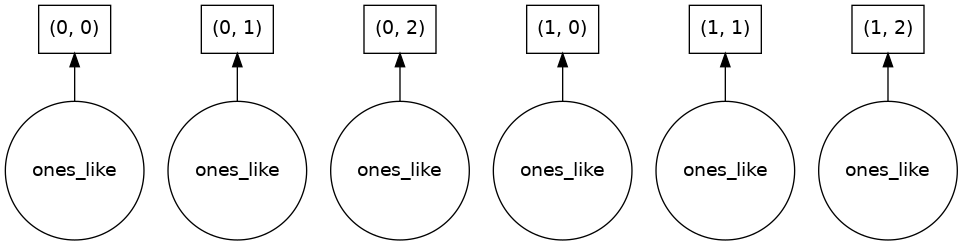

In [9]:
# visualize task graph 
ones_da.visualize()

## Performance Comparison

To compare the performance between numpy and dask array, let's calculate the mean. 

In [10]:
%%time
# The %%time magic measures the execution time of the whole cell
ones_np.mean()

CPU times: user 17 ms, sys: 0 ns, total: 17 ms
Wall time: 18.5 ms


1.0

In [11]:
%%time
# Remember, we are not doing any computation here, just constructing our task graph
mean_of_ones_da = ones_da.mean()

CPU times: user 1.58 ms, sys: 0 ns, total: 1.58 ms
Wall time: 1.59 ms


So far with just constructed our task graph. Now let's calculate the mean using `compute`. 

In [12]:
%%time
mean_of_ones_da.compute()

CPU times: user 5.67 ms, sys: 1.9 ms, total: 7.57 ms
Wall time: 7.59 ms


1.0

Typically, when working with dask arrays, we do not want to generate the data right away by calling `.compute()` on a large array. We usually want to perform some computations that reduce the data size. For example, we might compute statistics like the mean or standard deviation.

Let's look at an example of taking the mean and visualize the task graph. Remember, that no actual computation is taking place until we call `.compute()`.

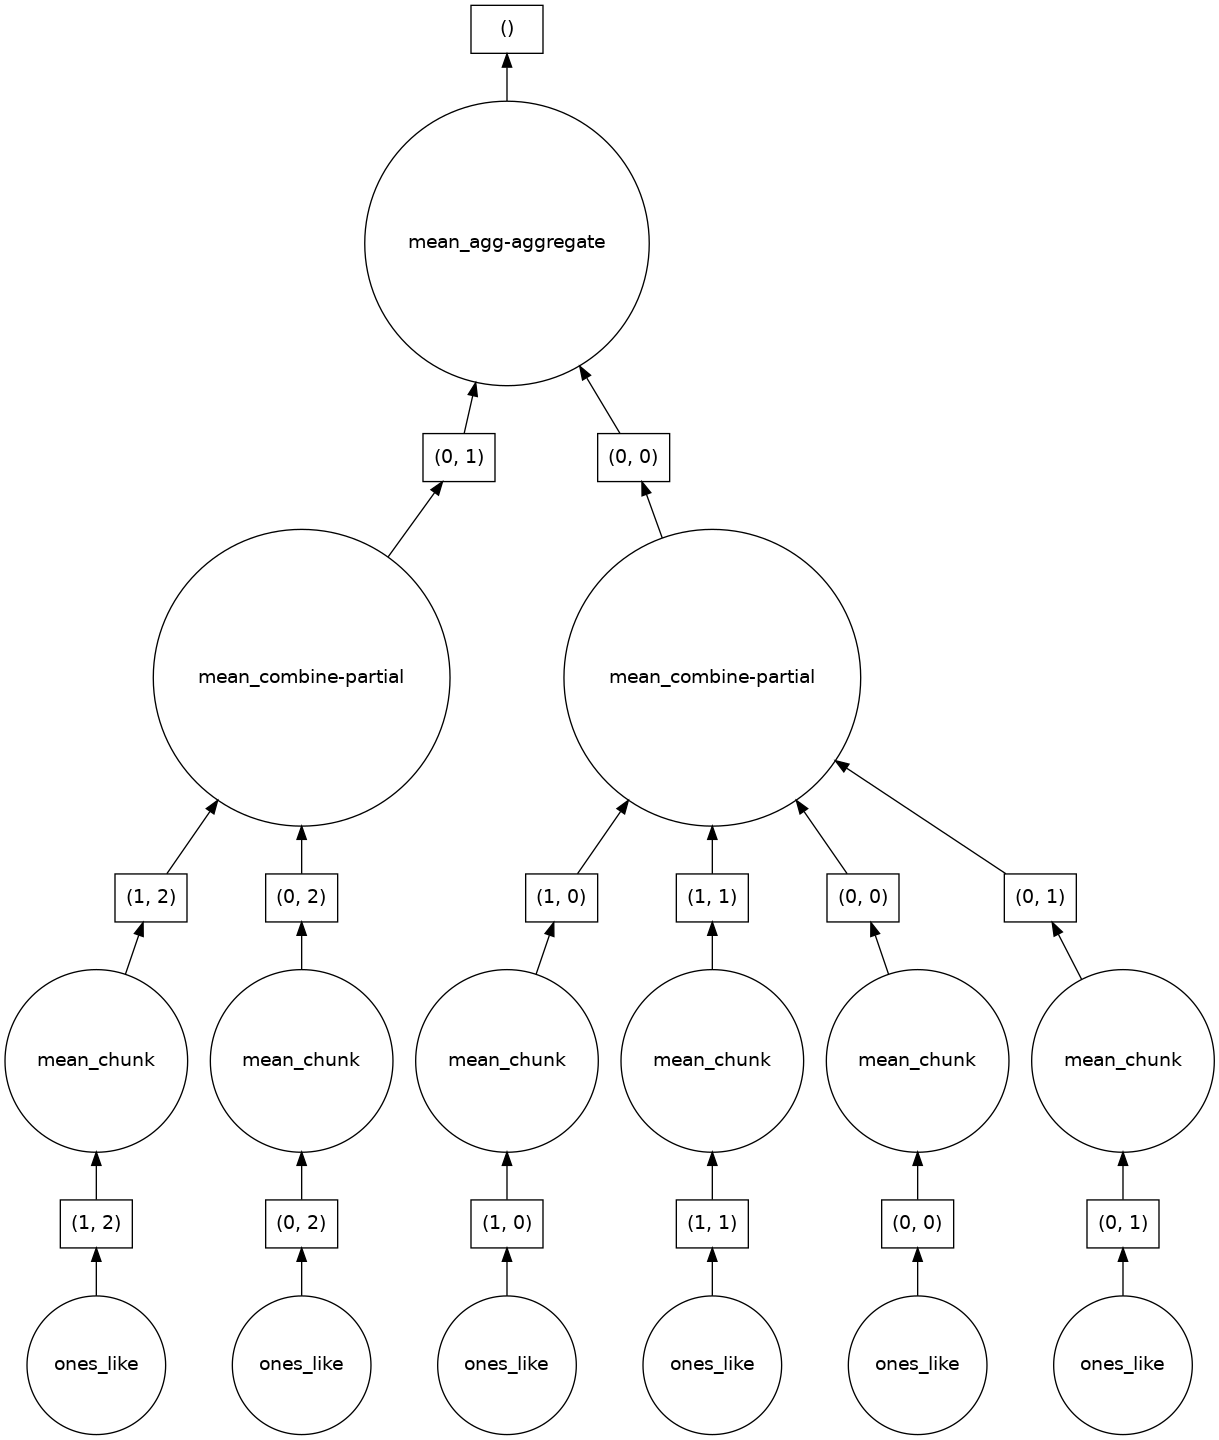

In [13]:
mean_of_ones_da = ones_da.mean()
mean_of_ones_da.visualize()

## Larger Data
The previous example illustrated how dask works, but wasn't really necessary for an array of size 32 MB. Let's try an example using bigger data and bigger calculations. 

In [17]:
big_shape = (40000, 20000)

big_ones_np = np.ones(big_shape)

Make a similar Dask Array with similar shape but specifying the `chunks` size:

In [26]:
chunk_shape = (2000,2000)
big_ones_da = da.ones(big_shape,chunks=chunk_shape)
big_ones_da

dask.array<ones_like, shape=(40000, 20000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

In [27]:
# size of data
print("Memory size of NumPy dataset :  {:.2f} GB".format(big_ones_np.nbytes / 1e9))
print("Memory size of Dask dataset  :  {:.2f} GB".format(big_ones_da.nbytes / 1e9))

Memory size of NumPy dataset :  6.40 GB
Memory size of Dask dataset  :  6.40 GB


This dataset is 3.2 GB, rather than MB! This may be close to the available memory/RAM that you have in your computer.

<div class="alert alert-block alert-warning">

<b>WARNING:</b> Do not try to `.visualize()` this array!

</div>

Let's try bigger calculations on this array:

In [28]:
%time 
z_np = big_ones_np * big_ones_np[::-1, ::-1].mean()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 90.4 µs


Bigger computations can take a bit more time, so dask has some built-in tools to help us follow what is happening.

In [30]:
%time
# perform big computation
from dask.diagnostics import ProgressBar

z_da = big_ones_da * big_ones_da[::-1, ::-1].mean()

with ProgressBar():
    result = z_da.compute()


CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.53 µs
[########################################] | 100% Completed | 2.33 sms


All the usual NumPy functions work on dask arrays and the computations with remain lazy until you either call `.compute()`, `.load()` or your want to plot the data.

As we discussed above, the way that Dask arrays are chunked can significantly affect the performance.

<div class="alert alert-block alert-warning">

<b>WARNING:</b> The way that arrays are chunked can significantly affect total performance. Poor chunking can singifincantly worsen performance of Dask compared to NumPy. 
</div>

For example, let's do a similar calculation using a different `chunks` size. 


## Rechunking Arrays

We can change the chunking of a Dask array, using the `rechunk` method. Please note that rechunking Dask arrays might become very expensive. 

In [31]:
new_chunk_shape = (200,200)
rechunked_big_ones_da = big_ones_da.rechunk(new_chunk_shape)
rechunked_big_ones_da

dask.array<rechunk-merge, shape=(40000, 20000), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>

In [32]:
%time
# perform big computation on chunked array

z_da_rechunked = rechunked_big_ones_da * rechunked_big_ones_da[::-1, ::-1].mean()

with ProgressBar():
    result = z_da_rechunked.compute()

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 97.8 µs
[########################################] | 100% Completed | 26.76 s


We can see how the choice of smaller chunks (more total chunks) **significantly** reduce the total performance of our computation. 

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> As a rule of thumb, a chunk should be big enough so that the computation on that chunk take significantly longer than the overhead from Dask scheduler. The Dask scheduler takes roughly 1ms per task for scheduling. 

</div>

Let's try a bigger chunk size:

In [38]:
new_chunk_shape = (20000,20000)
rechunked_big_ones_da = big_ones_da.rechunk(new_chunk_shape)
rechunked_big_ones_da

dask.array<rechunk-merge, shape=(40000, 20000), dtype=float64, chunksize=(20000, 20000), chunktype=numpy.ndarray>

In [39]:
%time
# perform big computation on chunked array

z_da_rechunked = rechunked_big_ones_da * rechunked_big_ones_da[::-1, ::-1].mean()

with ProgressBar():
    result = z_da_rechunked.compute()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
[########################################] | 100% Completed | 6.29 sms


Here we have two chunk sizes that are ~3GB each. If our array was bigger, we had even loading the array on our memory. 
<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> As a rule of thumb, a chunk should be small enough to fit comfortably in the memory. Chunk sizes between 10MB-1GB are common, depending on your machine,

</div>


Please note that rechunking Dask arrays might become very expensive, so specifying an initial chunk size appropriate for your array is important. Do we want to discuss this further? ****** How about automatic rechunking?

## Summary:



## Resources and references

* Reference
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    *  [Xarray Docs](https://xarray.pydata.org/)
  
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
     *   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests
    
* Pieces of this notebook are adapted from the following sources
  * https://github.com/dask/dask-tutorial/blob/main/03_array.ipynb
  * https://github.com/xarray-contrib/xarray-tutorial/blob/master/scipy-tutorial/06_xarray_and_dask.ipynb
  


 <div class="admonition alert alert-success">
    <p class="title" style="font-weight:bold">Previous: <a href="./00-dask-overview.ipynb">Dask Overview</a></p>
     <p class="title" style="font-weight:bold">Next: <a href="./02-dask-dataframe.ipynb">Dask DataFrame</a></p>
    
</div>